In [ ]:
!pip install pyrealsense2
!pip install mediapipe
!pip install opencv-python

In [1]:
!git clone https://github.com/Dryjelly/Face_Ear_Landmark_Detection.git

Cloning into 'Face_Ear_Landmark_Detection'...


In [6]:
!python ./Face_Ear_Landmark_Detection/train_face.py

Traceback (most recent call last):
  File "./Face_Ear_Landmark_Detection/train_face2ear.py", line 13, in <module>
    model_t = tf.keras.models.load_model('saved_model/saved_model_openpose_face_v1.h5', compile=False)
  File "c:\Users\ban\anaconda3\envs\nocap\lib\site-packages\keras\src\saving\saving_api.py", line 238, in load_model
    return legacy_sm_saving_lib.load_model(
  File "c:\Users\ban\anaconda3\envs\nocap\lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "c:\Users\ban\anaconda3\envs\nocap\lib\site-packages\keras\src\saving\legacy\save.py", line 234, in load_model
    raise IOError(
OSError: No file or directory found at saved_model/saved_model_openpose_face_v1.h5


In [8]:
!python ./Face_Ear_Landmark_Detection/demo_single.py

./Face_Ear_Landmark_Detection/demo_single.py:5: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter
Traceback (most recent call last):
  File "./Face_Ear_Landmark_Detection/demo_single.py", line 57, in <module>
    model = tf.keras.models.load_model('saved_mode/saved_model_openpose_ear_v1.h5', compile=False)
  File "c:\Users\ban\anaconda3\envs\nocap\lib\site-packages\keras\src\saving\saving_api.py", line 238, in load_model
    return legacy_sm_saving_lib.load_model(
  File "c:\Users\ban\anaconda3\envs\nocap\lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "c:\Users\ban\anaconda3\envs\nocap\lib\site-packages\keras\src\saving\legacy\save.py", line 234, in load_model
    raise IOError(
OSError: No file or directory found at saved_mode/saved_model_openpose_ear_v1.h5


In [1]:
import cv2
import numpy as np

In [5]:
def load_image(image_path):
    return cv2.imread(image_path)
def detect_face_and_shoulders(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    faces = face_cascade.detectMultiScale(gray, 1.1, 4)
    
    if len(faces) == 0:
        return None, None, None

    for (x, y, w, h) in faces:
        shoulder_y = y + int(1.5 * h)
        left_shoulder_x = x - int(0.5 * w)
        right_shoulder_x = x + int(1.5 * w)
        
        left_shoulder = (left_shoulder_x, shoulder_y)
        right_shoulder = (right_shoulder_x, shoulder_y)
        
        return (x, y, w, h), left_shoulder, right_shoulder

    return None, None, None
def calculate_shoulder_depth_diff(left_shoulder, right_shoulder):
    left_shoulder_depth = np.random.randint(1000, 2000)
    right_shoulder_depth = np.random.randint(1000, 2000)

    shoulder_diff = abs(left_shoulder_depth - right_shoulder_depth)
    return left_shoulder_depth, right_shoulder_depth, shoulder_diff
def main(image_path):
    # 이미지 불러오기
    image = load_image(image_path)
    
# 얼굴 및 어깨 탐지
    face, left_shoulder, right_shoulder = detect_face_and_shoulders(image)

    if face is None:
        print("얼굴을 탐지할 수 없습니다.")
        return
    
# 어깨 깊이 차이 계산
    left_shoulder_depth, right_shoulder_depth, shoulder_diff = calculate_shoulder_depth_diff(left_shoulder, right_shoulder)
    
    print(f"Left Shoulder Depth: {left_shoulder_depth} mm, Right Shoulder Depth: {right_shoulder_depth} mm")
    print(f"Shoulder Depth Difference: {shoulder_diff} mm")

# 결과 시각화
    (x, y, w, h) = face
    cv2.rectangle(image, (x, y), (x + w, y + h), (255, 0, 0), 2)
    cv2.circle(image, left_shoulder, 5, (0, 255, 0), -1)
    cv2.circle(image, right_shoulder, 5, (0, 255, 0), -1)
    
    cv2.imshow('Result', image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

In [3]:
## CODE FROM WANG FOR SHOULDER DETECTION ##
main('shoulder.jpg')

error: OpenCV(4.10.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\color.cpp:196: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'


Shaking head  
Shaking hand  
Shaking leg  
Unbalance of shoulders  
Unbalance of upper body  
Length of each leg  
Turtle neck  

In [6]:
import pyrealsense2 as rs
import cv2
import numpy as np
import mediapipe as mp

# MediaPipe Pose model
mp_pose = mp.solutions.pose
pose = mp_pose.Pose()

# Determine camera type and open the appropriate stream
use_realsense = is_realsense_camera()

if use_realsense:
    print("Using RealSense Camera")
    pipeline = open_realsense_camera()
else:
    print("Using Raspberry Pi Camera")
    cap = open_raspberry_pi_camera()

# Create a window to display the video
cv2.namedWindow('Camera View', cv2.WINDOW_AUTOSIZE)

# Initialize lists to store landmarks data
landmarks_data = [[] for _ in range(33)]

try:
    while True:
        if use_realsense:
            # Wait for a coherent pair of frames: depth and color
            frames = pipeline.wait_for_frames()
            color_frame = frames.get_color_frame()
            if not color_frame:
                continue

            # Convert images to numpy arrays
            color_image = np.asanyarray(color_frame.get_data())
        else:
            ret, color_image = cap.read()
            if not ret:
                continue

        # To improve performance, optionally mark the image as not writeable to pass by reference
        color_image.flags.writeable = False
        color_image = cv2.cvtColor(color_image, cv2.COLOR_BGR2RGB)
        results = pose.process(color_image)

        # Draw the pose annotation on the image.
        color_image.flags.writeable = True
        color_image = cv2.cvtColor(color_image, cv2.COLOR_RGB2BGR)

        if results.pose_landmarks:
            mp.solutions.drawing_utils.draw_landmarks(
                color_image, results.pose_landmarks, mp_pose.POSE_CONNECTIONS)

            # Extract landmark information and save to the respective lists
            for id, landmark in enumerate(results.pose_landmarks.landmark):
                h, w, _ = color_image.shape
                cx, cy, cz = int(landmark.x * w), int(landmark.y * h), int(landmark.z * w)
                landmarks_data[id].append([cx, cy, cz])
                
        cv2.imshow('Camera View', color_image)

        # Press 'q' to exit
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

finally:
    if use_realsense:
        pipeline.stop()
    else:
        cap.release()
    cv2.destroyAllWindows()

# Print the length of each list to verify the data
for i, landmark_list in enumerate(landmarks_data):
    print(f'Landmark {i} data length: {len(landmark_list)}')


Using Raspberry Pi Camera
Landmark 0 data length: 236
Landmark 1 data length: 236
Landmark 2 data length: 236
Landmark 3 data length: 236
Landmark 4 data length: 236
Landmark 5 data length: 236
Landmark 6 data length: 236
Landmark 7 data length: 236
Landmark 8 data length: 236
Landmark 9 data length: 236
Landmark 10 data length: 236
Landmark 11 data length: 236
Landmark 12 data length: 236
Landmark 13 data length: 236
Landmark 14 data length: 236
Landmark 15 data length: 236
Landmark 16 data length: 236
Landmark 17 data length: 236
Landmark 18 data length: 236
Landmark 19 data length: 236
Landmark 20 data length: 236
Landmark 21 data length: 236
Landmark 22 data length: 236
Landmark 23 data length: 236
Landmark 24 data length: 236
Landmark 25 data length: 236
Landmark 26 data length: 236
Landmark 27 data length: 236
Landmark 28 data length: 236
Landmark 29 data length: 236
Landmark 30 data length: 236
Landmark 31 data length: 236
Landmark 32 data length: 236


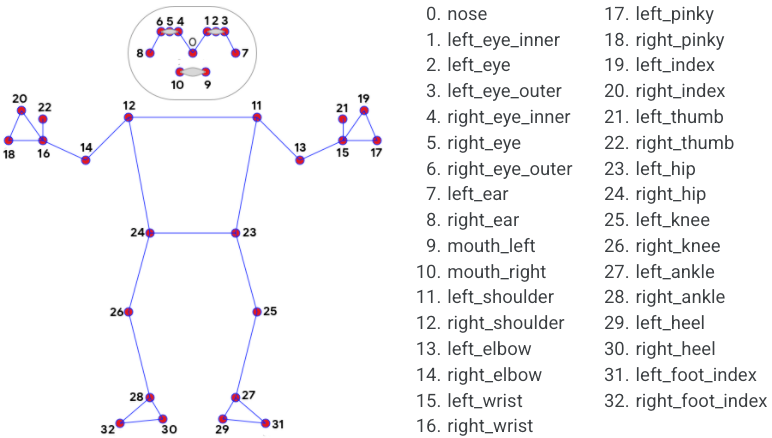

NOSE (코)  
LEFT_EYE_INNER (왼쪽 눈의 안쪽)  
LEFT_EYE (왼쪽 눈)  
LEFT_EYE_OUTER (왼쪽 눈의 바깥쪽)  
RIGHT_EYE_INNER (오른쪽 눈의 안쪽)  
RIGHT_EYE (오른쪽 눈)  
RIGHT_EYE_OUTER (오른쪽 눈의 바깥쪽)  
LEFT_EAR (왼쪽 귀)############  
RIGHT_EAR (오른쪽 귀)############  
MOUTH_LEFT (왼쪽 입꼬리)  
MOUTH_RIGHT (오른쪽 입꼬리)  
LEFT_SHOULDER (왼쪽 어깨)############  
RIGHT_SHOULDER (오른쪽 어깨)############  
LEFT_ELBOW (왼쪽 팔꿈치)  
RIGHT_ELBOW (오른쪽 팔꿈치)  
LEFT_WRIST (왼쪽 손목)  
RIGHT_WRIST (오른쪽 손목)  
LEFT_PINKY (왼쪽 새끼손가락)  
RIGHT_PINKY (오른쪽 새끼손가락)  
LEFT_INDEX (왼쪽 집게손가락)  
RIGHT_INDEX (오른쪽 집게손가락)  
LEFT_THUMB (왼쪽 엄지손가락)  
RIGHT_THUMB (오른쪽 엄지손가락)  
LEFT_HIP (왼쪽 엉덩이)  
RIGHT_HIP (오른쪽 엉덩이)  
LEFT_KNEE (왼쪽 무릎)############  
RIGHT_KNEE (오른쪽 무릎)############  
LEFT_ANKLE (왼쪽 발목)  
RIGHT_ANKLE (오른쪽 발목)  
LEFT_HEEL (왼쪽 발꿈치)  
RIGHT_HEEL (오른쪽 발꿈치)  
LEFT_FOOT_INDEX (왼쪽 발가락)  
RIGHT_FOOT_INDEX (오른쪽 발가락)  

In [5]:
results = pose.process(image)
lm = results.pose_landmarks
lmPose = mp_pose.PoseLandmark
l_shldr_x = int(lm.landmark[lmPose.LEFT_SHOULDER].x * w)
l_shldr_y = int(lm.landmark[lmPose.LEFT_SHOULDER].y * h)
r_shldr_x = int(lm.landmark[lmPose.RIGHT_SHOULDER].x * w)
r_shldr_y = int(lm.landmark[lmPose.RIGHT_SHOULDER].y * h)
l_ear_x = int(lm.landmark[lmPose.LEFT_EAR].x * w)
l_ear_y = int(lm.landmark[lmPose.LEFT_EAR].y * h)
l_hip_x = int(lm.landmark[lmPose.LEFT_HIP].x * w)
l_hip_y = int(lm.landmark[lmPose.LEFT_HIP].y * h)

NameError: name 'image' is not defined

In [7]:
blue = (255, 127, 0)
red = (50, 50, 255)
green = (127, 255, 0)
dark_blue = (127, 20, 0)
light_green = (127, 233, 100)
yellow = (0, 255, 255)
pink = (255, 0, 255)
black = (0, 0, 0)

In [8]:
import math as m
def findDistance(x1, y1, x2, y2):
    dist = m.sqrt((x2-x1)**2+(y2-y1)**2)
    return dist
def findStandard(x1, y1, x2, y2, x3, y3):
    #어깨 중앙 포인트 ~ 관자도리 포인트까지의 거리
    center_shldr_x = (x2+x1)/2
    center_shldr_y = (y2+y1)/2
    standard = findDistance(x3, y3, center_shldr_x, center_shldr_y)
    return int(standard)
def findAngle(x1, y1, x2, y2):
    theta = m.acos((y2 -y1)*(-y1) / (m.sqrt((x2 - x1)**2 + (y2 - y1)**2) * y1))
    degree = int(180/m.pi)*theta
    return degree
def sendWarning(x):
    pass

In [9]:
# side view body allignment guide function
def sideAlign(image,l_shldr_x, l_shldr_y, r_shldr_x, r_shldr_y):
    offset = findDistance(l_shldr_x, l_shldr_y, r_shldr_x, r_shldr_y)
    if offset < 100:
        # Case of two shoulder points are alligned properly
        # r_shldr point color varies by situation
        print('Aligned')
        cv2.circle(image, (l_shldr_x, l_shldr_y), 14, green, 1)
        cv2.circle(image, (r_shldr_x, r_shldr_y), 7, green, -1)
    else:
        print('Not Aligned')
        cv2.circle(image, (l_shldr_x, l_shldr_y), 14, black, 1)
        cv2.circle(image, (r_shldr_x, r_shldr_y), 7, pink, -1)

def NerdNeckSlice(image,l_shldr_x, l_shldr_y, r_shldr_x, r_shldr_y, l_ear_x, l_ear_y, l_hip_x, l_hip_y):
    standard = findStandard(l_shldr_x, l_shldr_y, r_shldr_x, r_shldr_y, l_ear_x, l_ear_y)
    neck_inclination = findAngle(l_shldr_x, l_shldr_y, l_ear_x, l_ear_y)
    torso_inclination = findAngle(l_hip_x, l_hip_y, l_shldr_x, l_shldr_y)
    if neck_inclination < 15:
        neck_state = 0
        cv2.circle(image, (l_shldr_x, l_shldr_y - standard), 14, green, 1)
        cv2.circle(image, (l_ear_x, l_ear_y), 7, green, -1)
        print('Alive')
    else:
        neck_state = 1
        cv2.circle(image, (l_shldr_x, l_shldr_y - standard), 14, black, 1)
        cv2.circle(image, (l_ear_x, l_ear_y), 7, pink, -1)
        print('Dead')

    if torso_inclination < 10:
        torso_state=0
        cv2.line(image, (l_hip_x, l_hip_y), (l_hip_x, l_hip_y - 100), green, 10)
        cv2.line(image, (l_hip_x, l_hip_y), (l_shldr_x, l_shldr_y), green, 10)
    else:
        torso_state=1
        cv2.line(image, (l_hip_x, l_hip_y), (l_hip_x, l_hip_y - 100), black, 10)
        cv2.line(image, (l_hip_x, l_hip_y), (l_shldr_x, l_shldr_y), pink, 10)


    """if neck_state == 0 and torso_state==0:
        bad_frames = 0
        good_frames += 1
    else:
        good_frames = 0
        bad_frames += 1"""

In [10]:
import pyrealsense2 as rs
import cv2
import numpy as np
import mediapipe as mp

def is_realsense_camera():
    ctx = rs.context()
    if len(ctx.devices) > 0:
        return True
    return False

def open_realsense_camera():
    # Configure depth and color streams
    pipeline = rs.pipeline()
    config = rs.config()
    config.enable_stream(rs.stream.depth, 640, 480, rs.format.z16, 30)
    config.enable_stream(rs.stream.color, 640, 480, rs.format.bgr8, 30)

    # Start streaming
    pipeline.start(config)
    return pipeline

def open_raspberry_pi_camera():
    cap = cv2.VideoCapture(0)
    if not cap.isOpened():
        raise ValueError("Unable to open the Raspberry Pi camera")
    return cap

In [12]:
import pyrealsense2 as rs
import cv2
import numpy as np
import mediapipe as mp
import time
import math as m


# MediaPipe Pose model
mp_pose = mp.solutions.pose
pose = mp_pose.Pose()

# Determine camera type and open the appropriate stream
use_realsense = is_realsense_camera()

if use_realsense:
    print("Using RealSense Camera")
    pipeline = open_realsense_camera()
else:
    print("Using Raspberry Pi Camera")
    cap = open_raspberry_pi_camera()

# Create a window to display the video
cv2.namedWindow('Camera View', cv2.WINDOW_AUTOSIZE)

# Initialize lists to store landmarks data
landmarks_data = [[] for _ in range(33)]

try:
    while True:
        if use_realsense:
            # Wait for a coherent pair of frames: depth and color
            frames = pipeline.wait_for_frames()
            color_frame = frames.get_color_frame()
            if not color_frame:
                continue

            # Convert images to numpy arrays
            color_image = np.asanyarray(color_frame.get_data())
        else:
            ret, color_image = cap.read()
            if not ret:
                continue

        # To improve performance, optionally mark the image as not writeable to pass by reference
        color_image.flags.writeable = False
        color_image = cv2.cvtColor(color_image, cv2.COLOR_BGR2RGB)
        results = pose.process(color_image)

        # Draw the pose annotation on the image.
        color_image.flags.writeable = True
        color_image = cv2.cvtColor(color_image, cv2.COLOR_RGB2BGR)

        """if results.pose_landmarks:
            mp.solutions.drawing_utils.draw_landmarks(
                color_image, results.pose_landmarks, mp_pose.POSE_CONNECTIONS)

            # Extract landmark information and save to the respective lists
            for id, landmark in enumerate(results.pose_landmarks.landmark):
                h, w, _ = color_image.shape
                cx, cy, cz = int(landmark.x * w), int(landmark.y * h), int(landmark.z * w)
                landmarks_data[id].append([cx, cy, cz])"""

        # Display the resulting image
        lm = results.pose_landmarks
        lmPose = mp_pose.PoseLandmark
        l_shldr_x = int(lm.landmark[lmPose.LEFT_SHOULDER].x * w)
        l_shldr_y = int(lm.landmark[lmPose.LEFT_SHOULDER].y * h)
        r_shldr_x = int(lm.landmark[lmPose.RIGHT_SHOULDER].x * w)
        r_shldr_y = int(lm.landmark[lmPose.RIGHT_SHOULDER].y * h)
        l_ear_x = int(lm.landmark[lmPose.LEFT_EAR].x * w)
        l_ear_y = int(lm.landmark[lmPose.LEFT_EAR].y * h)
        l_hip_x = int(lm.landmark[lmPose.LEFT_HIP].x * w)
        l_hip_y = int(lm.landmark[lmPose.LEFT_HIP].y * h)
        NerdNeckSlice(color_image,l_shldr_x, l_shldr_y, r_shldr_x, r_shldr_y, l_ear_x, l_ear_y,l_hip_x, l_hip_y)
        cv2.imshow('Camera View', color_image)

        # Press 'q' to exit
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

finally:
    if use_realsense:
        pipeline.stop()
    else:
        cap.release()
    cv2.destroyAllWindows()

# Print the length of each list to verify the data
for i, landmark_list in enumerate(landmarks_data):
    print(f'Landmark {i} data length: {len(landmark_list)}')


Using Raspberry Pi Camera
Dead
Dead
Dead
Dead
Dead
Dead
Dead
Dead
Dead
Dead
Dead
Dead
Dead
Dead
Dead
Dead
Dead
Dead
Dead
Dead
Dead
Dead
Dead
Dead
Dead
Dead
Dead
Dead
Dead
Dead
Dead
Dead
Dead
Dead
Dead
Dead
Dead
Dead
Dead
Dead
Dead
Dead
Dead
Dead
Dead
Dead
Dead
Dead
Dead
Dead
Dead
Dead
Dead
Dead
Dead
Dead
Dead
Dead
Dead
Dead
Dead
Dead
Dead
Dead
Dead
Dead
Dead
Dead
Dead
Dead
Dead
Dead
Dead
Dead
Dead
Dead
Dead
Dead
Dead
Dead
Dead
Dead
Dead
Dead
Dead
Dead
Dead
Dead
Dead
Dead
Dead
Dead
Dead
Dead
Dead
Dead
Dead
Dead
Dead
Dead
Dead
Dead
Dead
Dead
Dead
Dead
Dead
Dead
Dead
Dead
Dead
Dead
Dead
Dead
Dead
Dead
Dead
Dead
Dead
Dead
Dead
Dead
Dead
Dead
Dead
Dead
Dead
Dead
Dead
Dead
Dead
Dead
Dead
Dead
Dead
Dead
Dead
Dead
Dead
Dead
Dead
Dead
Dead
Dead
Dead
Dead
Dead
Dead
Dead
Dead
Dead
Dead
Dead
Dead
Dead
Dead
Dead
Dead
Dead
Dead
Dead
Dead
Dead
Dead
Dead
Dead
Dead
Dead
Dead
Dead
Dead
Dead
Dead
Dead
Dead
Dead
Landmark 0 data length: 0
Landmark 1 data length: 0
Landmark 2 data length: 0
Landmark 3 data 

## SHAKING HEAD

Frequency of head tremor  
떨림의 빈도 측정  
Human pose estimation을 통해 추출된 머리의 랜드마크 데이터 사용
코 or 귀  
랜드마크 데이터의 좌표변화 시계열 저장  
주기 분석을 통해 좌표 변동 주기 분석, 주기와 떨림의 빈도 반비례  


In [ ]:
import numpy as np
from scipy.fft import fft

# 랜드마크 데이터 예시: 코의 x 좌표
nose_x = [item[0] for item in landmarks_data[0]]  # 시간에 따른 코의 x 좌표 값
l_ear = np.array([item[0] for item in landmarks_data[7]]).reshape(-1, 1)
r_ear = np.array([item[0] for item in landmarks_data[8]]).reshape(-1, 1)

# 두 배열을 세로로 합치기
#ear = np.concatenate((l_ear, r_ear), axis=1)
#head_size = 
#head_size = sum(r_ear - l_ear)/len(l_ear)
#7,8
#noseFreq = minmax
# 푸리에 변환 수행
# 20=1, 
T = 1.0 / 1200.0  # 샘플링 주기 (예: 30Hz)
N = len(nose_x)
t = np.linspace(0.0, N*T, N, endpoint=False)

fft_values = fft(nose_x)
frequencies = np.fft.fftfreq(len(nose_x),T)


# 떨림의 주파수(빈도) 확인
amplitude = np.abs(fft_values)
tremor_frequency = frequencies[np.argmax(amplitude[1:]) + 1]

print("Tremor frequency:", tremor_frequency)
HZ = frequencies[1:N//2][np.argmax(amplitude[1:N//2])]
if HZ<3:
    print("No Problem")
elif 3<=HZ<5:
    print("Slow")
elif 5<=HZ<8:
    print("Mid")
elif 9<=HZ<12:
    print("HIgh")
else:
    print("WTF")

Tremor frequency: 6.521739130434782
Mid


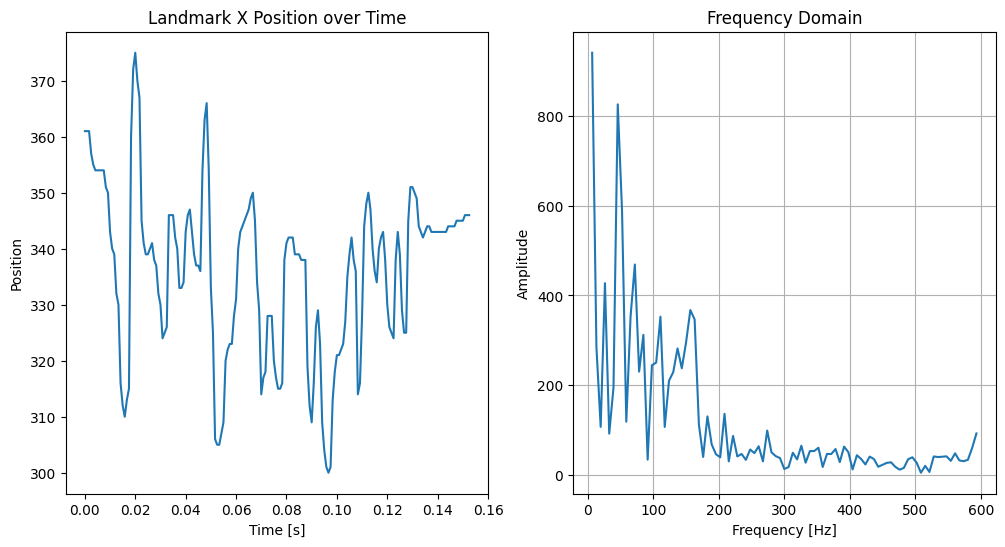

In [167]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(t, nose_x)
plt.title('Landmark X Position over Time')
plt.xlabel('Time [s]')
plt.ylabel('Position')

plt.subplot(1, 2, 2)
plt.plot(frequencies[1:N//2], amplitude[1:N//2])  # DC 성분(0번째)은 제외
plt.title('Frequency Domain')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Amplitude')
plt.grid()
plt.show()

In [152]:
HZ = frequencies[1:N//2][np.argmax(amplitude[1:N//2])]
if HZ < 3:
    print("No Problem")
elif 3<=HZ<5:
    print("Slow")
elif 5<=HZ<8:
    print("Mid")
elif 9<=HZ<12:
    print("HIgh")
else:
    print("WTF")

1.0328638497652582

intensity of a head tremor  
떨림의 강도 측정  
랜드마크 좌표와 이전 프레임의 좌표 차이로 변위 계산  
시간에 따른 변위의 평균 및 표준 편차를 계산하여 떨림의 강도를 측정  
변위와 떨림의 강도 비례

In [176]:
# 시간에 따른 랜드마크 좌표
landmark_x = [item[0] for item in landmarks_data[0]]
landmark_y = [item[0] for item in landmarks_data[1]]

# 변위 계산
displacement = np.sqrt(np.diff(landmark_x)**2 + np.diff(landmark_y)**2)

# 평균 변위 및 표준 편차 계산
mean_displacement = np.mean(displacement)
std_displacement = np.std(displacement)

Shaking Leg  
사용 랜드마크 포인트: left_leg, right_leg  
Landmark 25 data length: 540  
Landmark 26 data length: 540  
Low:3~5  
Mid:6~10  
High:10~18  

stand position
stable 4~7
기립성 떨림 13~18



In [183]:
l_leg = np.array([item[0] for item in landmarks_data[24]]).reshape(-1, 1)
r_leg = np.array([item[0] for item in landmarks_data[25]]).reshape(-1, 1)

T = 1.0 / 1200.0  # 샘플링 주기 (예: 30Hz)
N = len(l_leg)
t = np.linspace(0.0, N*T, N, endpoint=False)

l_leg_fft_values = fft(l_leg)
r_leg_fft_values = fft(r_leg)
frequencies = np.fft.fftfreq(N,T)

# 떨림의 주파수(빈도) 확인
l_leg_amplitude = np.abs(l_leg_fft_values)
r_leg_amplitude = np.abs(r_leg_fft_values)

l_tremor_frequency = frequencies[np.argmax(l_leg_amplitude[1:]) + 1]
r_tremor_frequency = frequencies[np.argmax(r_leg_amplitude[1:]) + 1]

print("Left Tremor frequency:", l_tremor_frequency)
print("Right Tremor frequency:", r_tremor_frequency)

LHZ = frequencies[1:N//2][np.argmax(amplitude[1:N//2])]
RHZ = frequencies[1:N//2][np.argmax(amplitude[1:N//2])]

Left Tremor frequency: -576.7955801104972
Right Tremor frequency: 411.049723756906


In [ ]:
if 3 <= LHZ < 5:
    print("Low")
elif 6 <= LHZ < 10:
    print("Mid")
elif 11 <= LHZ <

hand shake  
4~7: 파킨슨 떨림
4 이상은 위험
대칭성 > 본태성
비대칭성 > 파킨슨

Turtle neck detection process

In [10]:
def findDistance(x1, y1, x2, y2):
    dist = m.sqrt((x2-x1)**2+(y2-y1)**2)
    return dist
def findStandard(x1, y1, x2, y2, x3, y3):
    #어깨 중앙 포인트 ~ 관자도리 포인트까지의 거리
    center_shldr_x = (x2+x1)/2
    center_shldr_y = (y2+y1)/2
    standard = findDistance(x3, y3, center_shldr_x,center_shldr_y)
    return standard
def findAngle(x1, y1, x2, y2):
    theta = m.acos((y2 -y1)*(-y1) / (m.sqrt((x2 - x1)**2 + (y2 - y1)**2) * y1))
    degree = int(180/m.pi)*theta
    return degree
def sendWarning(x):
    pass

In [11]:
blue = (255, 127, 0)
red = (50, 50, 255)
green = (127, 255, 0)
dark_blue = (127, 20, 0)
light_green = (127, 233, 100)
yellow = (0, 255, 255)
pink = (255, 0, 255)
black = (0, 0, 0)

In [ ]:
neck_inclination = findAngle(l_shldr_x, l_shldr_y, l_ear_x, l_ear_y)
torso_inclination = findAngle(l_hip_x, l_hip_y, l_shldr_x, l_shldr_y)

In [ ]:
if neck_inclination < 40 and torso_inclination < 10:
    bad_frames = 0
    good_frames += 1
else:
    good_frames = 0
    bad_frames += 1

good_time = (1 / fps) * good_frames
bad_time =  (1 / fps) * bad_frames

if good_time > 0:
    time_string_good = 'Good Posture Time : ' + str(round(good_time, 1)) + 's'
    print(time_string_good)
else:
    time_string_bad = 'Bad Posture Time : ' + str(round(bad_time, 1)) + 's'
    print(time_string_bad)

if bad_time > 180:
    sendWarning()